In [1]:
import pandas as pd
import anndata
import joblib
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.5
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

## Cell tidy data

In [33]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [38]:
cluster_cg_median = cell_tidy_data.groupby('SubType')['CG_Rate'].median()

## REPTILE Scores

In [3]:
reptile_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/REPTILE/result/REPTILE_scores.subtype.h5ad'
)
enhancer_hits = pd.Series((reptile_adata.X > 0.5).sum(axis=1).A1, index=reptile_adata.obs_names)
use_dmr = enhancer_hits[enhancer_hits>3].index

In [4]:
use_dmr.size

759629

## DMR Rate

In [5]:
dmr_rate = pd.read_hdf( 
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5', key='Rate'
).loc[use_dmr].copy()

dmr_bed = pd.read_hdf( 
    '/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5', key='bed'
).loc[use_dmr].copy()

## Intersect

In [6]:
fedmr_bed = pybedtools.BedTool('/home/hanliu/ref/inhouse/He_2020_Nature_Mouse_Tissue_Developmental/feDMR.bed')
_dmr_bed = pybedtools.BedTool.from_dataframe(dmr_bed.reset_index().iloc[:, [1, 2, 3, 0]])
fe_dmr_intersect = _dmr_bed.intersect(fedmr_bed, v=True).to_dataframe()

use_dmr = pd.Index(fe_dmr_intersect['name'])

## Cluster orders

In [7]:
exc_dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.dendrogram.lib'
)
inh_dendro = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Inh.dendrogram.lib'
)

cluster_order = exc_dendro['ivl'] + inh_dendro['ivl']
name_map = {i.replace('-', '.').replace('_', '.'): i for i in dmr_rate.columns}
cluster_order = [name_map[i] for i in cluster_order]

In [41]:
cluster_cg_median.index = cluster_cg_median.index.map(lambda i: i.replace(' ', '_'))
cluster_cg_median = cluster_cg_median[cluster_order]

## ENCODE Profile

In [8]:
encode_adata = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/CompareREPTILE/AnnotateDMRWithENCODE/SubType.DMR.ENCODE_FB_anno.h5ad'
)[use_dmr, :].copy()

encode_adata = encode_adata[:, encode_adata.var.sort_values(['DataType', 'DevTime', 'Rep']).index].copy()

## Kmeans order by DMR Rate PC

In [48]:
from sklearn.cluster import MiniBatchKMeans
mbk = MiniBatchKMeans(init='k-means++', n_clusters=10, 
                      batch_size=100,
                      n_init=10, max_no_improvement=10, verbose=0,
                      random_state=0)
from sklearn.decomposition import PCA
pca = PCA(n_components=15)

In [49]:
pcs = pca.fit_transform(dmr_rate.loc[use_dmr].fillna(0.8))

In [50]:
mbk.fit(pcs)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=10, random_state=0,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [51]:
ordered_dmr = use_dmr[mbk.labels_.argsort()]

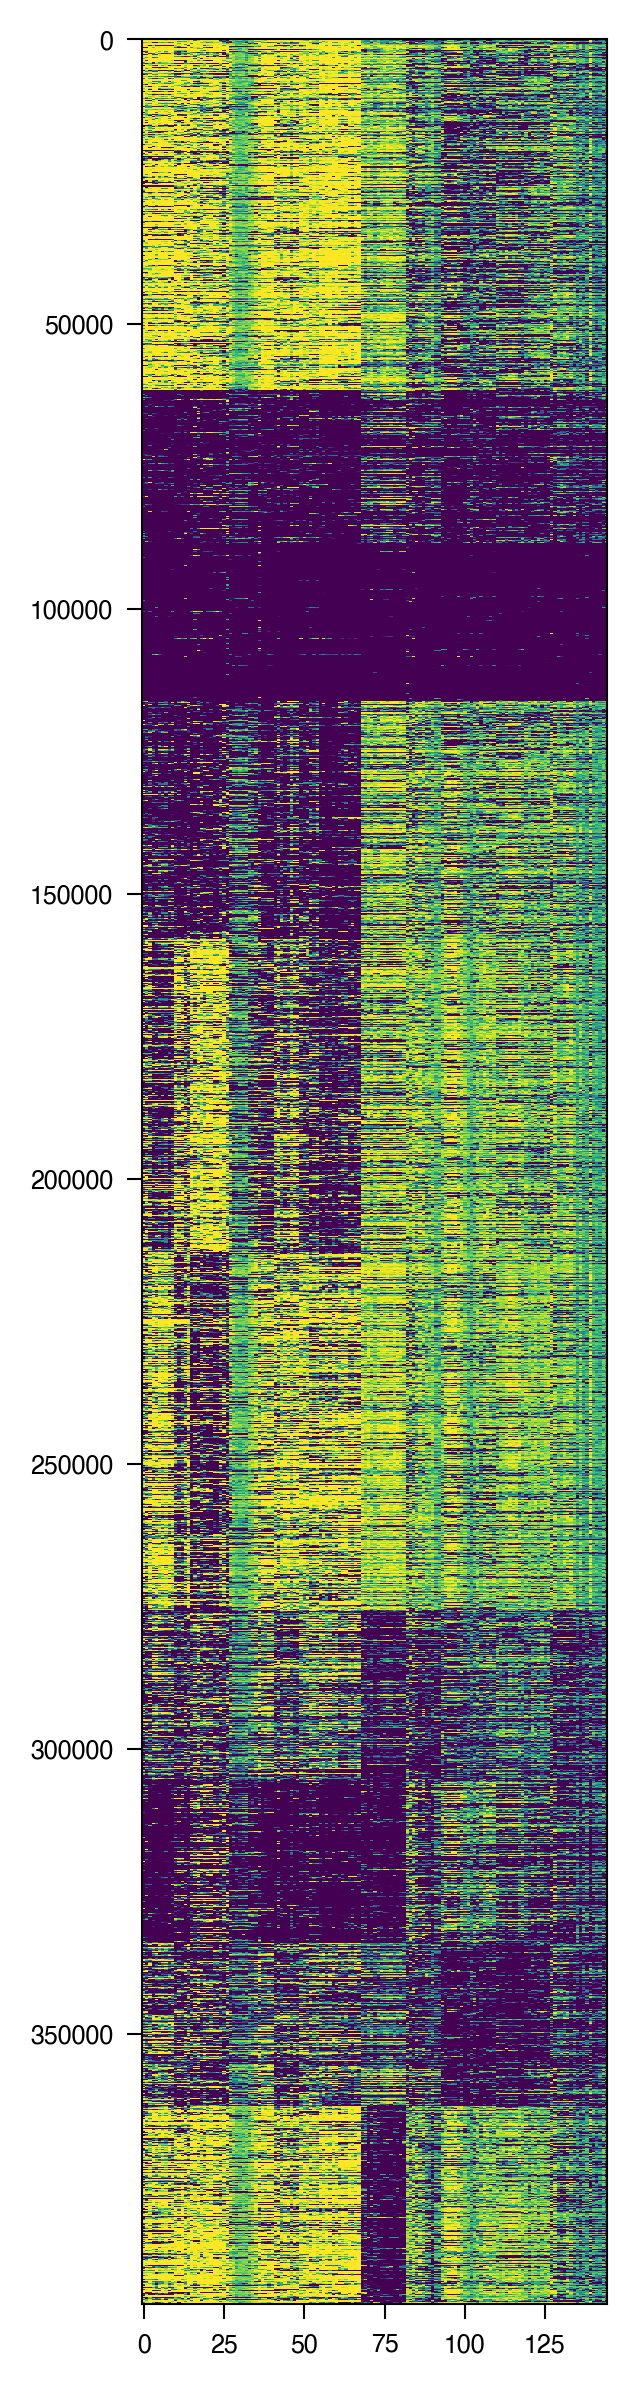

In [52]:
fig, ax = plt.subplots(figsize=(2, 10), dpi=300)
img_data = dmr_rate.loc[ordered_dmr, cluster_order].fillna(0.8)

ax.imshow(scaler.fit_transform(img_data), aspect='auto', vmin=0, vmax=1)

## Dev ATAC

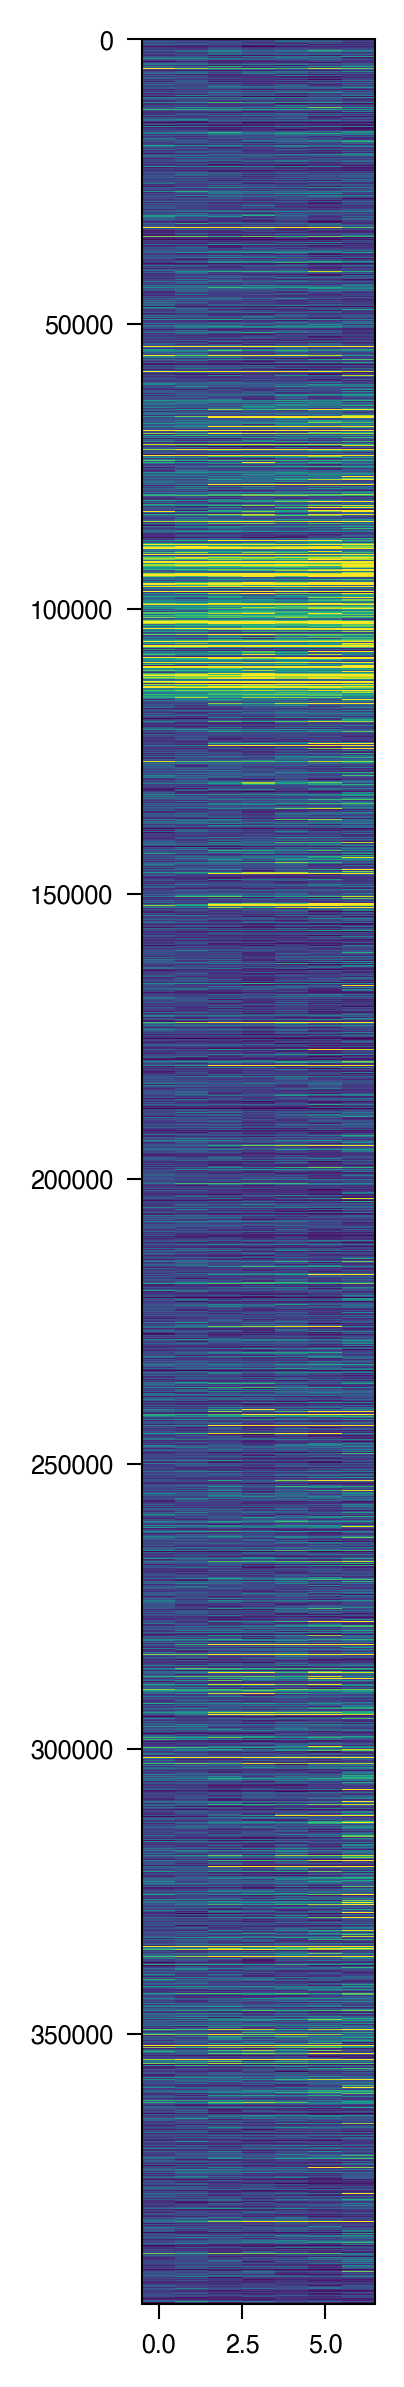

In [53]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'ATAC']
ax.imshow(img_data, vmin=0, vmax=3,
          aspect='auto')

## Dev mCG

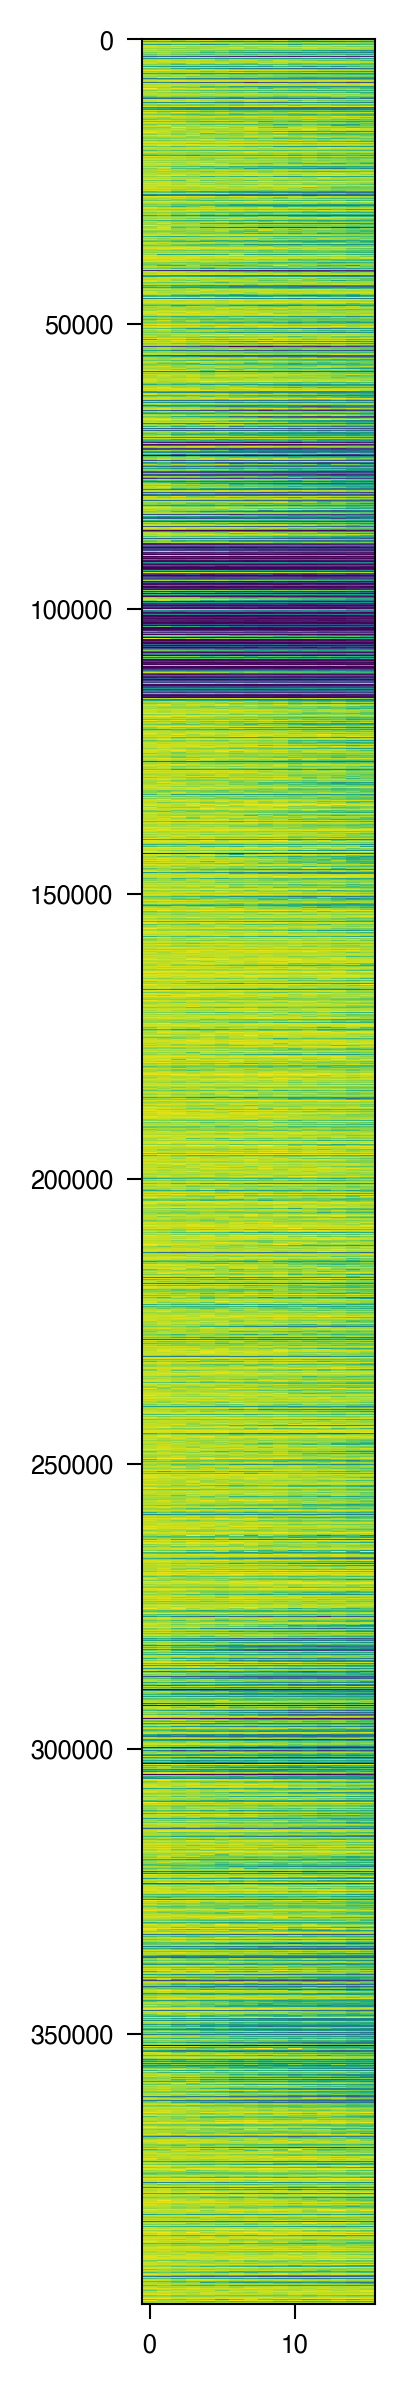

In [54]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'CGN']
ax.imshow(img_data, vmin=0, vmax=1,
          aspect='auto')

## Dev mCA

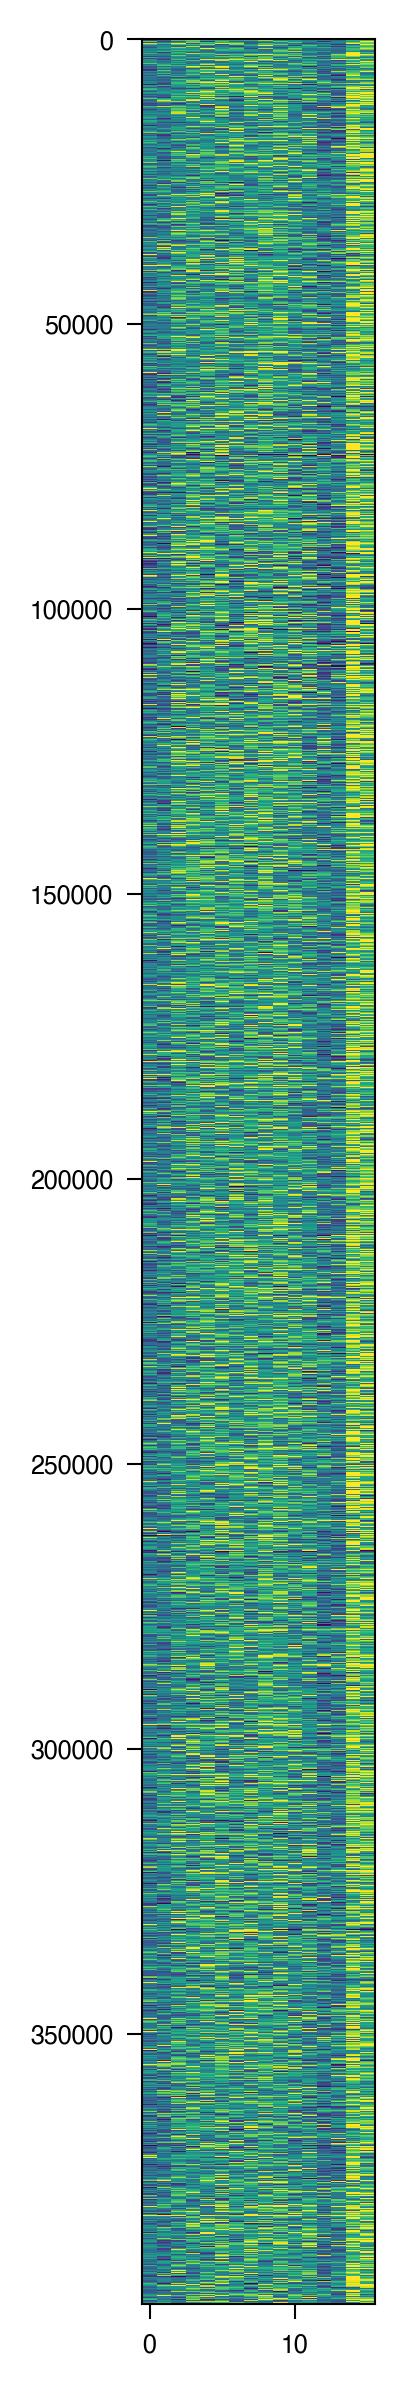

In [55]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'CAN']
ax.imshow(img_data, vmin=0, vmax=0.01,
          aspect='auto')

## Dev mCH

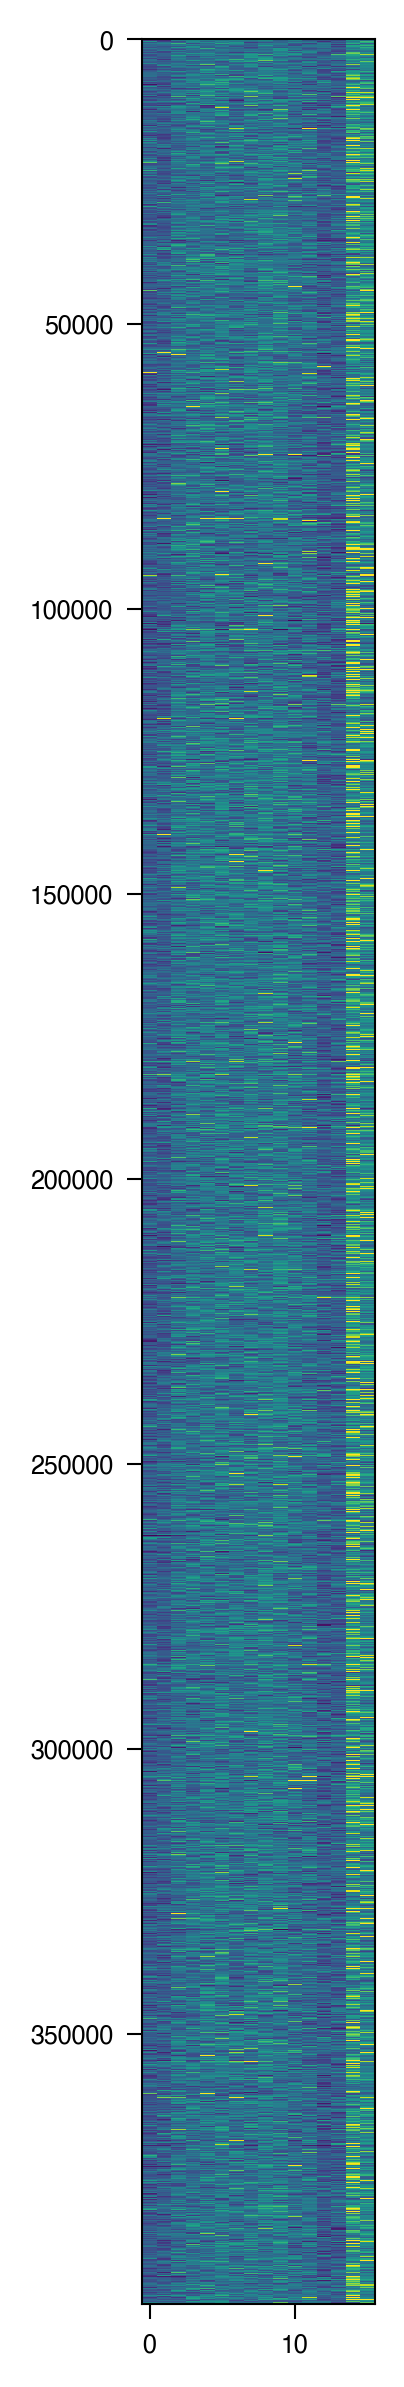

In [56]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'CHN']
ax.imshow(img_data, vmin=0, vmax=0.01,
          aspect='auto')

## ChIP

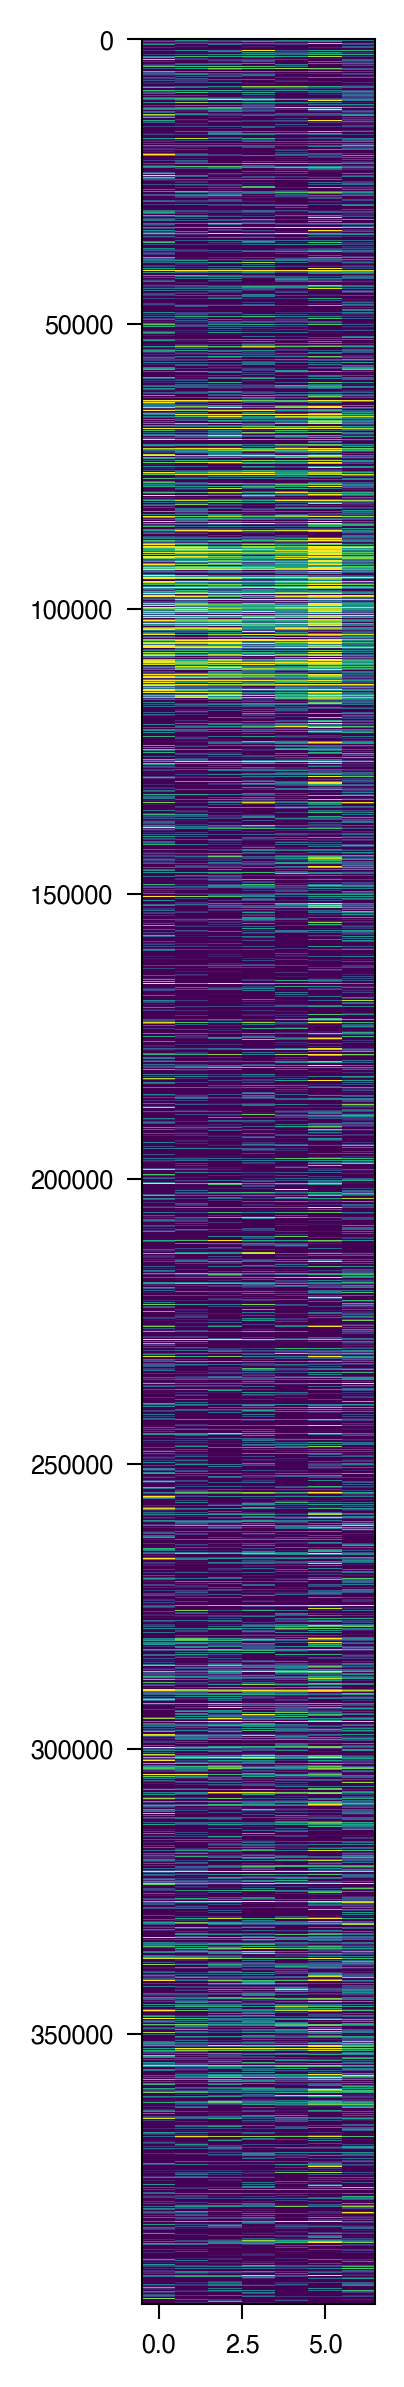

In [57]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'H3K4me1']
ax.imshow(img_data, vmin=0, vmax=2,
          aspect='auto')

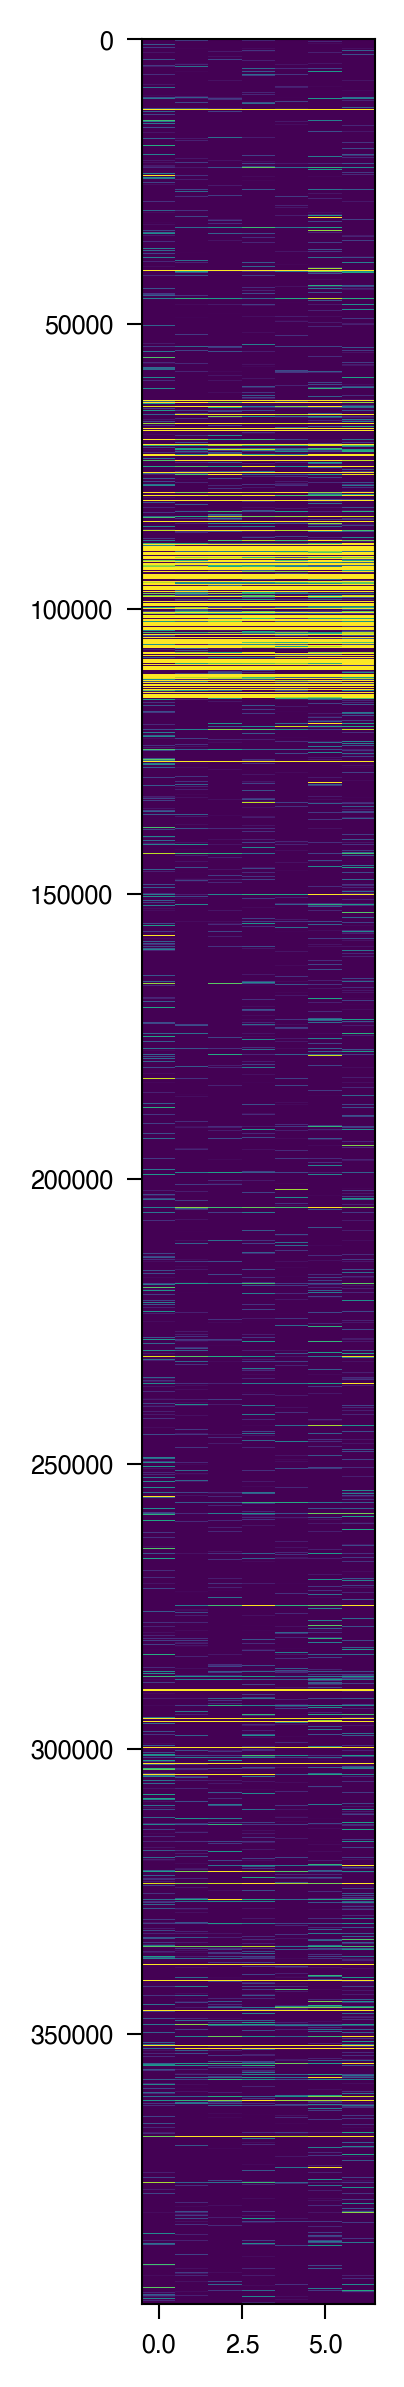

In [58]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'H3K4me2']
ax.imshow(img_data, vmin=0, vmax=2,
          aspect='auto')

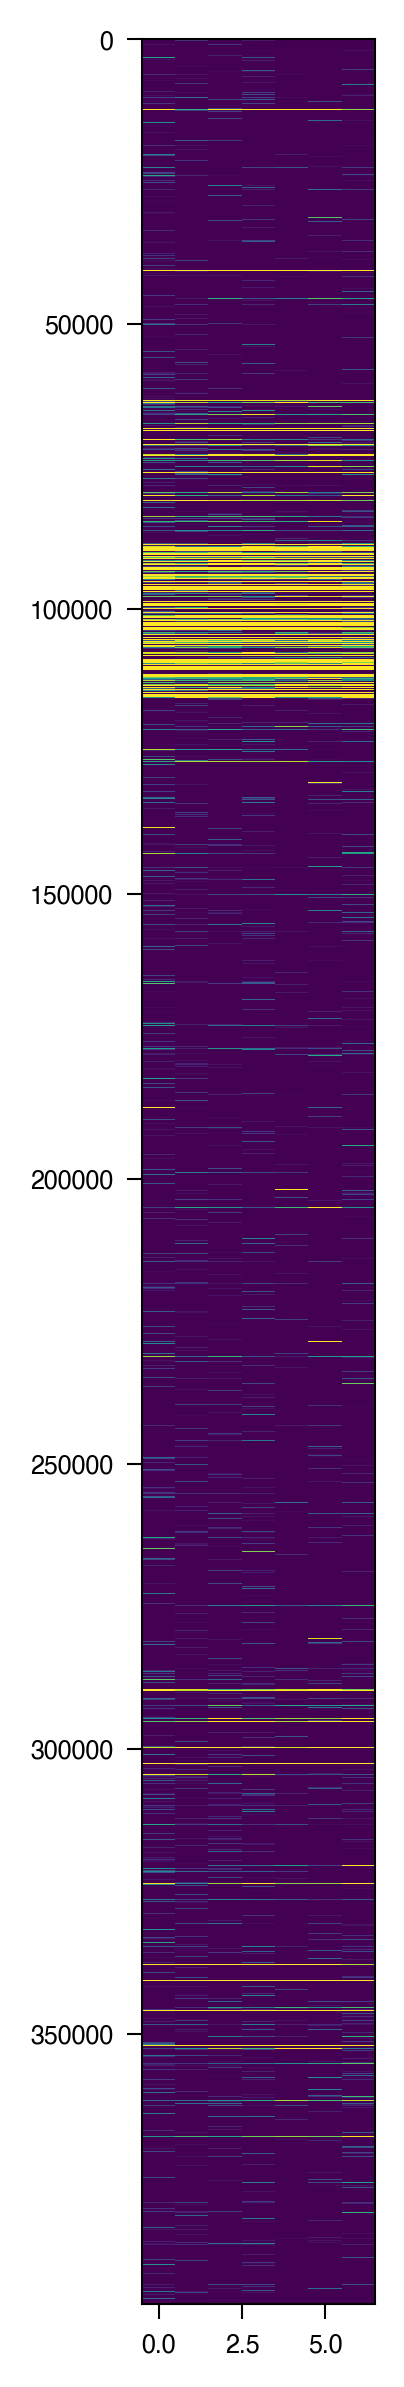

In [59]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'H3K4me3']
ax.imshow(img_data, vmin=0, vmax=2,
          aspect='auto')

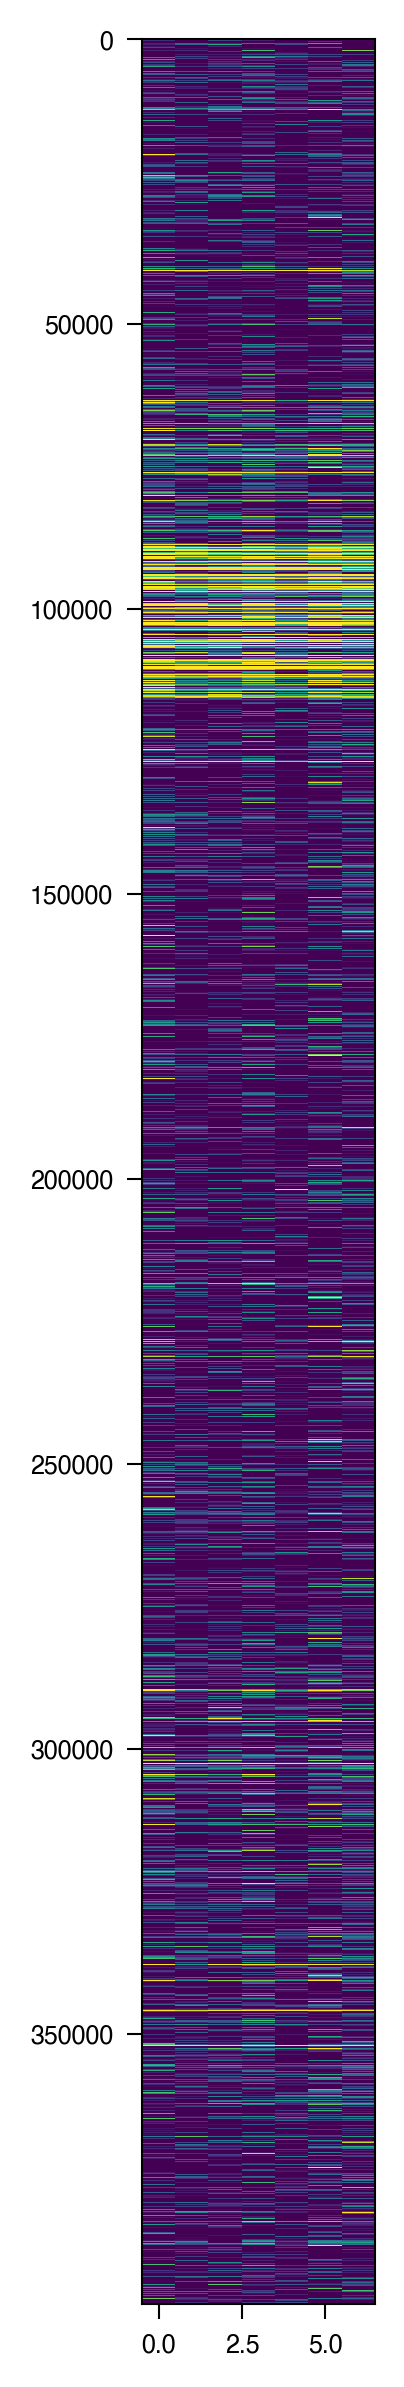

In [60]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'H3K9ac']
ax.imshow(img_data, vmin=0, vmax=2,
          aspect='auto')

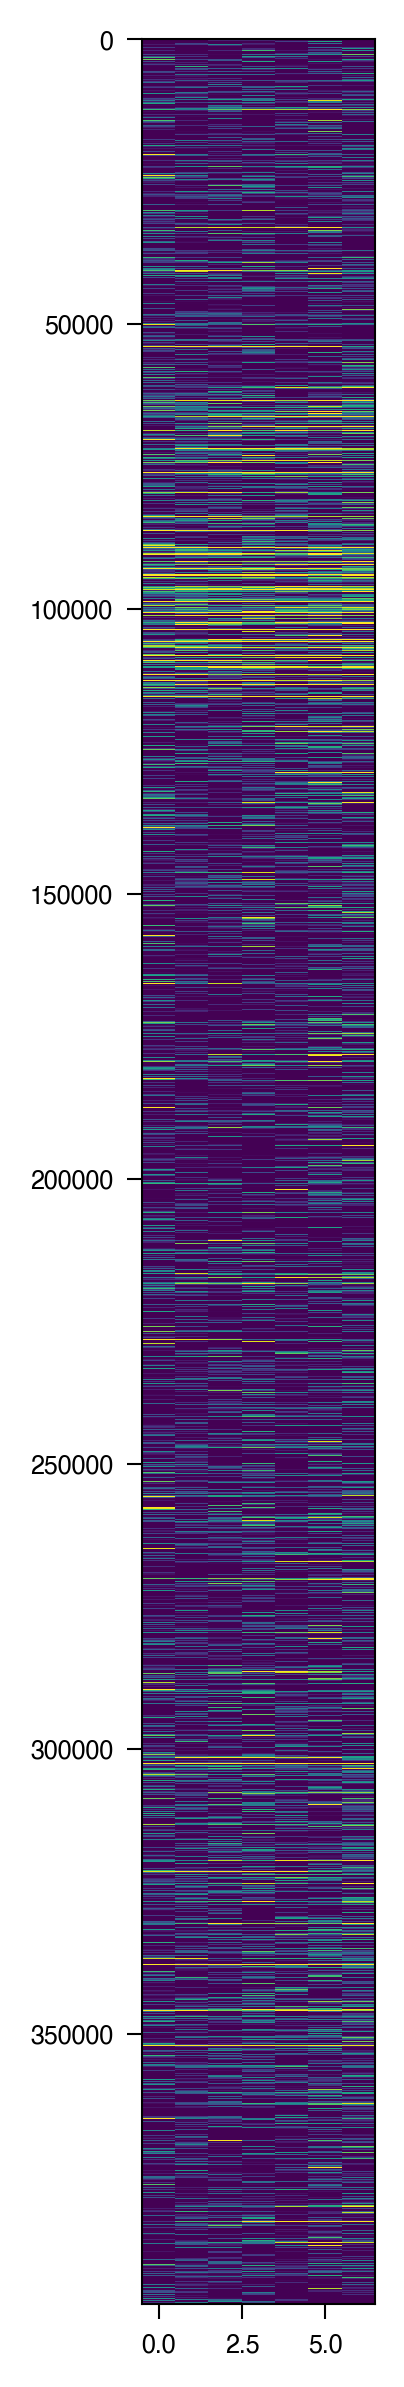

In [61]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'H3K27ac']
ax.imshow(img_data, vmin=0, vmax=2,
          aspect='auto')

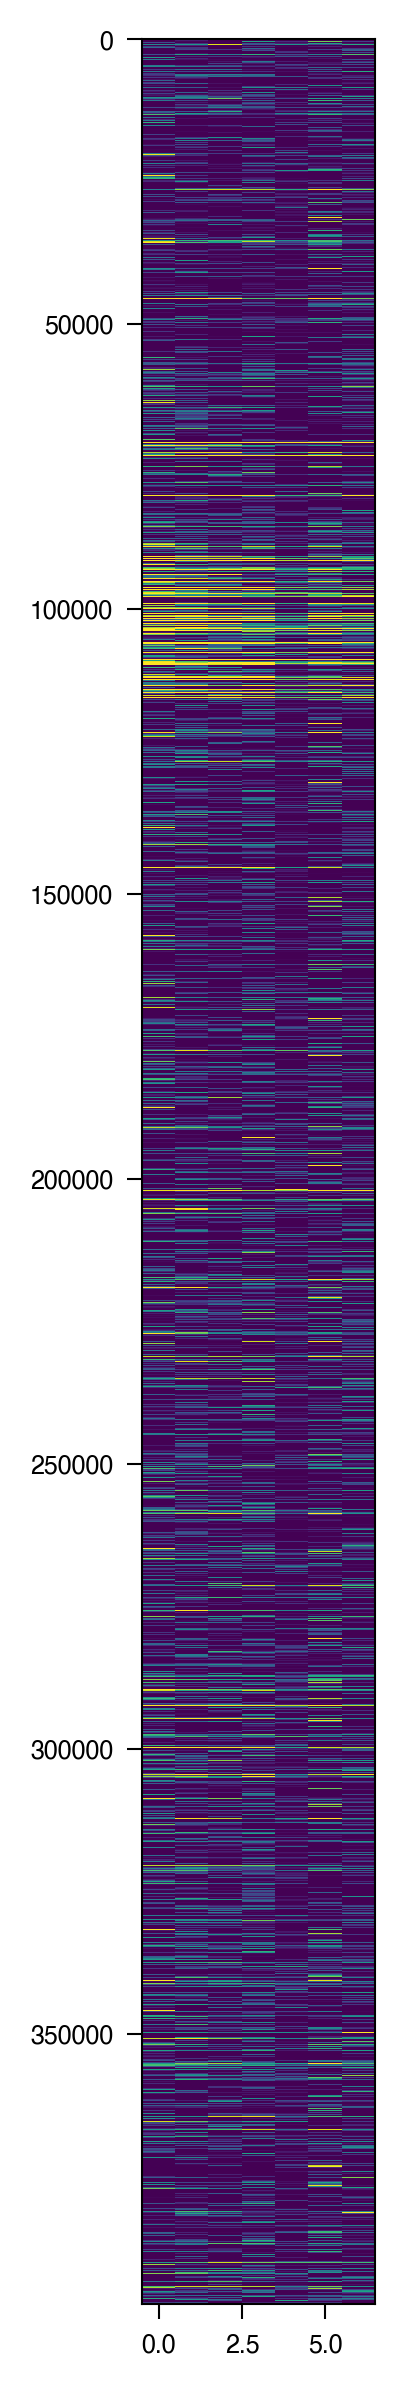

In [62]:
fig, ax = plt.subplots(figsize=(1, 10), dpi=300)
img_data = encode_adata[ordered_dmr, :].X.todense()[:, encode_adata.var['DataType'] == 'H3K27me3']
ax.imshow(img_data, vmin=0, vmax=2,
          aspect='auto')

In [63]:
encode_adata.var['DataType'].unique()

[ATAC, CAN, CGN, CHN, H3K4me1, H3K4me2, H3K4me3, H3K9ac, H3K27ac, H3K27me3]
Categories (10, object): [ATAC, CAN, CGN, CHN, ..., H3K4me3, H3K9ac, H3K27ac, H3K27me3]

In [64]:
encode_adata.var

,DataType,DevTime,Rep,input_path
index,,,,
ATAC_E11.5_1,ATAC,E11.5,1,ATAC_E11.5_1.tab
ATAC_E12.5_1,ATAC,E12.5,1,ATAC_E12.5_1.tab
ATAC_E13.5_1,ATAC,E13.5,1,ATAC_E13.5_1.tab
ATAC_E14.5_1,ATAC,E14.5,1,ATAC_E14.5_1.tab
ATAC_E15.5_1,ATAC,E15.5,1,ATAC_E15.5_1.tab
ATAC_E16.5_1,ATAC,E16.5,1,ATAC_E16.5_1.tab
ATAC_P0_1,ATAC,P0,1,ATAC_P0_1.tab
CAN_E10.5_1,CAN,E10.5,1,CAN_E10.5_1.tab
CAN_E10.5_2,CAN,E10.5,2,CAN_E10.5_2.tab
